# Pylops - optimization

### Author: M.Ravasi

In this notebook I will show how to use some of the high-level functions of *Pylops* that have been implemented to solve large-scale inverse problem with different regularization terms.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.signal import triang

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

# Basic unconstrained least-squares inversion

To start let's consider once again the problem of *linear regression*. Expressing this problem in a matrix form $\mathbf{y}=  \mathbf{A} \mathbf{x}$ we aim to minimize the following cost function

$$ J= ||\mathbf{y} - \mathbf{A} \mathbf{x}||_2 $$


This overdetermined problem can be solved using explicit matrix solvers as well as iterative solvers. We will use the latter (more specifically the scipy implementation of *LSQR* solver) as it will not be possible to explicitely invert some of the large-scale optimization problems that we are interested to solve.

We will consider two different starting guesses:

* starting guess equal 0
* arbitrary choice of starting guess

First with starting guess equal 0

In [2]:
# parameters
N = 30
x = np.array([1., 2.])

# set up problem
t = np.arange(N, dtype='float64')
LRop = LinearRegression(t, dtype='float64')
dottest(LRop, N, 2, verb=True)

y = LRop*x

# LSQR solver
xlsqr, istop, itn, r1norm, r2norm = lsqr(LRop, y, damp=1e-10, iter_lim=10 ,show=0)[0:5]

print('x=',x)
print('lsqr solution xest=', xlsqr)

Dot test passed, v^T(Opu)=-70.451254 - u^T(Op^Tv)=-70.451254
x= [1. 2.]
lsqr solution xest= [1. 2.]


And with initial guess different from 0. This can be done by solving the equivalent problem

$$\mathbf{y} - \mathbf{A} \mathbf{x_0} = \mathbf{A} \mathbf{\Delta x} $$
$$\mathbf{x} = \mathbf{x_0}  + \mathbf{\Delta x} $$

In [3]:
x0 = np.array([5., 3.])

y0 = LRop*x0
yr = y-y0

dxlsqr, istop, itn, r1norm, r2norm = lsqr(LRop, yr, damp=1e-10, iter_lim=10 ,show=0)[0:5]
xlsqr = x0 + dxlsqr

print('x=',x)
print('lsqr solution xest=', xlsqr)

x= [1. 2.]
lsqr solution xest= [1. 2.]


#### Normal equations

In [4]:
xne = NormalEquationsInversion(LRop, None, y, x0=x0)

print('x=',x)
print('normal eqs solution xest=', xne)

x= [1. 2.]
normal eqs solution xest= [1. 2.]


#### Regularized inversion

In [5]:
xreg = RegularizedInversion(LRop, [], y, x0=x0)

print('x=',x)
print('reg inv. solution xest=', xreg)

x= [1. 2.]
reg inv. solution xest= [1. 2.]


In [6]:
#### Preconditioned inversion

In [7]:
xprec = PreconditionedInversion(LRop, Identity(2), y, x0=x0)
    
print('x=',x)
print('precond inv. solution xest=', xprec)

x= [1. 2.]
precond inv. solution xest= [1. 2.]


### Perform weighted LS inversion with Normal equations and Regularized inversion

In [8]:
w = triang(N)
w1 = np.sqrt(w)

xne = NormalEquationsInversion(LRop, None,  y, Weight=Diagonal(w), **dict(maxiter=1))
xreg = RegularizedInversion(LRop, None,  y, Weight=Diagonal(w1), **dict(iter_lim=1))

print('x=',x)
print('normal eqs solution xest=', xne)
print('reg inv. solution xest=', xreg)
print(xne-xreg)

x= [1. 2.]
normal eqs solution xest= [0.1206359  2.05148054]
reg inv. solution xest= [0.1206359  2.05148054]
[4.16333634e-17 8.88178420e-16]


# Interpolation

## 1D Interpolation

Consider the problem of reconstructing a regularly sampled signal of size $M$ from $N$ randomly selected samples:


$$\mathbf{y} = \mathbf{R} \mathbf{x}$$

where

$$\mathbf{y}= [y_1, y_2,...,y_N]^T, \qquad \mathbf{x}= [x_1, x_2,...,x_M]^T, \qquad $$

with $M>>N$ and R selects M elements from x at random locations

Create signal in frequency domain

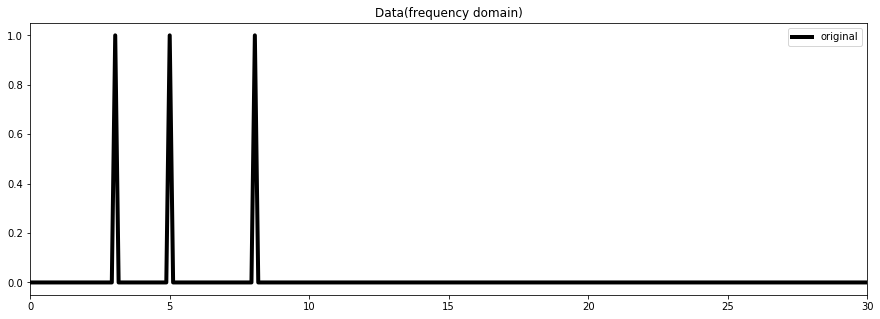

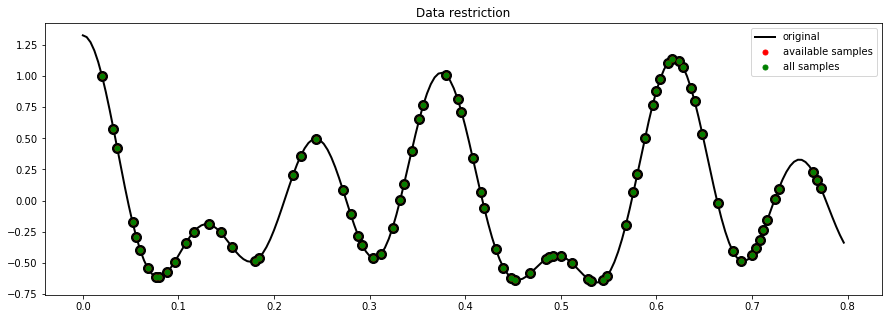

In [9]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(X),
         'k'   , LineWidth=4,   label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N)

y     = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,       'k' , LineWidth=2,   label='original')
plt.plot(t[iava], x[iava], '.k', MarkerSize=20)
plt.plot(t[iava], y,       '.r', MarkerSize=10, label='available samples')
plt.plot(t,       ymask,   '.g', MarkerSize=10, label='all samples')
plt.legend()
plt.title('Data restriction');

On in time domain

Time for some magic. Now that we have made an operator we would like to invert it and add some operators acting as regularization. In other words we want to minimize the following cost function

$$ J= ||\mathbf{y} - \mathbf{R} \mathbf{x}||_2 + \epsilon_\nabla^2 ||\nabla\mathbf{x}||_2 $$

One way is to write the cost function into the equivalent problem

$$ \begin{bmatrix}
        \mathbf{R}    \\
        \epsilon_\nabla \nabla       
   \end{bmatrix} \mathbf{x} = 
   \begin{bmatrix}
        \mathbf{y}    \\
        0      
   \end{bmatrix}
$$

and write an operator that performs the forward and adjoint operations. Finally we will feed this augmented operator to an iterative solver (e.g., LSQR) to efficiently solve this large-scale optimization problem. Such a problem is solved using the routine **lops.optimization.leastsquares.RegularizedInversion**.

lsqr reason for termination= 2
lsqr number of iterations= 156
lsqr residual norm of iterations= 0.059635985276607704
lsqr regularized residual norm= 0.09695724239703264


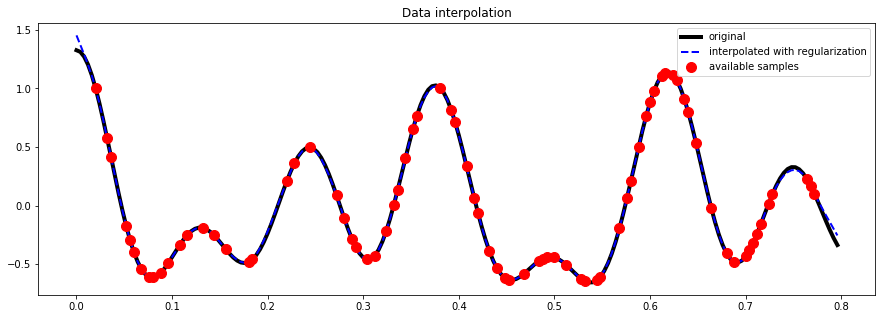

In [10]:
# Create regularization operator
D2op  = SecondDerivative(N, dims=None, dtype='float64')

# Invert for interpolated signal
xlsqr_reg_lop, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y, epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))

print('lsqr reason for termination=', istop)
print('lsqr number of iterations=', itn)
print('lsqr residual norm of iterations=', r1norm)
print('lsqr regularized residual norm=', r2norm)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , LineWidth=4,   label='original')
plt.plot(t,       xlsqr_reg_lop,  '--b' , LineWidth=2,   label='interpolated with regularization')
plt.plot(t[iava], y,              '.r'  , MarkerSize=20, label='available samples')
plt.legend()
plt.title('Data interpolation');

Alternatively we could write the normal equations and use an iterative solver for square systems (e.g., CG)

We can write this cost function into the equivalent problem

$$ \mathbf{x} = (\mathbf{R^TR}+\epsilon_\nabla^2\nabla^T\nabla)^{-1} \mathbf{R^Ty}$$

This can be done using the routine **lops.optimization.leastsquares.NormalEquationsInversion**.

cg reason for termination= 0


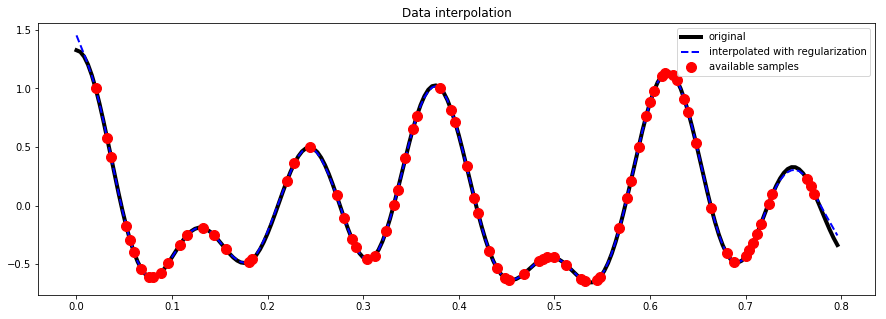

In [11]:
epsR=np.sqrt(0.1)
epsI=np.sqrt(1e-4)

x_cg_lop, istop = NormalEquationsInversion(Rop, [D2op], y, epsI=epsI, epsRs=[epsR], returninfo=True, 
                                           **dict(maxiter=200))

print('cg reason for termination=', istop)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , LineWidth=4,   label='original')
plt.plot(t,       x_cg_lop,  '--b' , LineWidth=2,   label='interpolated with regularization')
plt.plot(t[iava], y,              '.r'  , MarkerSize=20, label='available samples')
plt.legend()
plt.title('Data interpolation');

Alternatively, it is possible to write a preconditioned problem, whose cost function is

$$ J= ||\mathbf{y} - \mathbf{R} \mathbf{P} \mathbf{p}||_2 $$

where $\mathbf{P}$ is the precondioned operator, $\mathbf{p}$ is the projected model in the preconditioned space, and $\mathbf{x}=\mathbf{P}\mathbf{p}$ is the model in the original model space we want to solve for. Note that a preconditioned problem converges much faster to its solution than its corresponding regularized problem.

This can be done using the routine **lops.optimization.leastsquares.PreconditionedInversion**.

lsqr reason for termination= 7
lsqr number of iterations= 20
lsqr residual norm of iterations= 0.005658931493156796
lsqr regularized residual norm= 0.005665195055156905


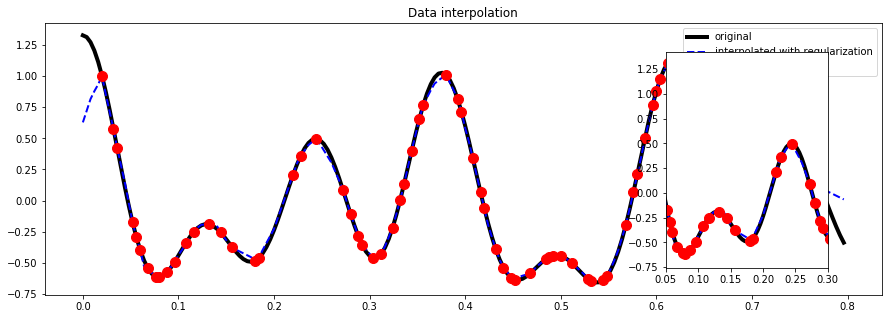

In [12]:
# Create regularization operator
Sop  = Smoothing1D(nsmooth=11, dims=[N], dtype='float64')
Sop
# Invert for interpolated signal
xlsqr_reg_lop, istop, itn, r1norm, r2norm = \
    PreconditionedInversion(Rop, Sop, y, returninfo=True,
                           **dict(damp=np.sqrt(1e-9), iter_lim=20 , show=0))

print('lsqr reason for termination=', istop)
print('lsqr number of iterations=', itn)
print('lsqr residual norm of iterations=', r1norm)
print('lsqr regularized residual norm=', r2norm)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , LineWidth=4,   label='original')
plt.plot(t,       xlsqr_reg_lop,  '--b' , LineWidth=2,   label='interpolated with regularization')
plt.plot(t[iava], y,              '.r'  , MarkerSize=20, label='available samples')
plt.legend()
plt.title('Data interpolation');
subax = fig.add_axes([0.7, 0.2, 0.15, 0.6])
subax.plot(t,       x,              'k'   , LineWidth=4,   label='original')
subax.plot(t,       xlsqr_reg_lop,  '--b' , LineWidth=2,   label='interpolated with regularization')
subax.plot(t[iava], y,              '.r'  , MarkerSize=20, label='available samples')
subax.set_xlim(0.05, 0.3);

### Sparsity promoting inversion

In several inverse problems in geophysics, prior information about the model space and its charactheristics is available. This information should be exploited as much as possible to regularize the inversion and speed-up convergence.

A common assumption is that the model is *sparse* in some domain: for example, if we aim to reconstruct an irregularly sampled signal that we believe to be composed by a finite set of sinusoids, its Fourier representation will be sparse (i.e, just a few spikes at the correct frequencies). 

In mathematical terms, solving for a sparse model is equivalent to add a regularization terms that requires to minimize the $L_0$ or $L_1$ norm of the model in the sparse domain:

$$ J_{L0} =  ||\mathbf{S} \mathbf{x}||_0, \quad   J_{L1} =  ||\mathbf{S} \mathbf{x}||_1$$

where $\mathbf{S}$ is the sparsify transform.

In this example, as the 1D signal is composed of three sinusoids, we can attempt to reconstruct the signal at regular intervals using a sparse solver in the Fourier domain. 

Let start by writing the forward model:
$$ \mathbf{y} = \mathbf{R} \mathbf{S} \mathbf{p} $$ 

where here the sparsity operator $\mathbf{S}$ is the 1D FFT operator (our FFT linear operator)
and the problem we want to solve:
$$ ||\mathbf{p}||_1 \qquad subject \quad to \qquad  \mathbf{y} = \mathbf{R} \mathbf{S} \mathbf{p} $$ 


Including such a term in a cost function is however challanging because both functional are non-convex. 

A variety of iterative solvers have been developed to solve such non-convex problem by subsquent linearizations: in thise example we will use both **ISTA** and **FISTA**, as well as **SPGL1**.

/Users/matteoravasi/anaconda/envs/pylops/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


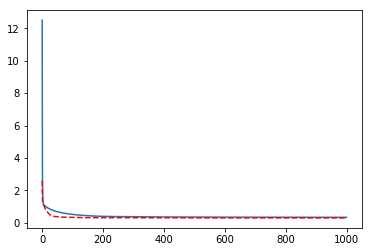

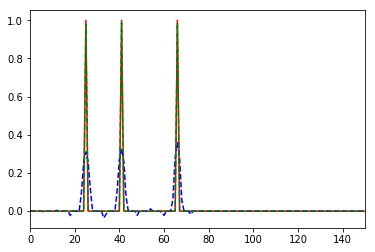

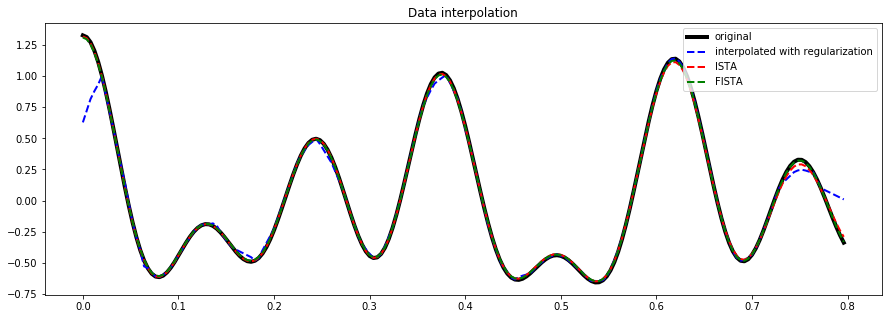

In [13]:
Xinv, niter, cost = ISTA(Rop*FFTop.H, y, niter=1000, eps=0.1, tol=1e-8, monitorres=False, 
                         returninfo=True)
xinv = FFTop.H*Xinv

Xinv1, niter1, cost1 = FISTA(Rop*FFTop.H, y, niter=1000, eps=0.1, tol=1e-8, returninfo=True)
xinv1 = FFTop.H*Xinv1

plt.figure()
plt.plot(cost)
plt.plot(cost1, '--r')

plt.figure()
plt.plot(X,'r')
plt.plot(Xinv, '--b')
plt.plot(Xinv1, '--g')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , LineWidth=4,   label='original')
plt.plot(t,       xlsqr_reg_lop,  '--b' , LineWidth=2,   label='interpolated with regularization')
plt.plot(t,       xinv,  '--r' , LineWidth=2,   label='ISTA')
plt.plot(t,       xinv1,  '--g' , LineWidth=2,   label='FISTA')
plt.legend()
plt.title('Data interpolation');

Restoring best iterate to objective 0.10505324904584347


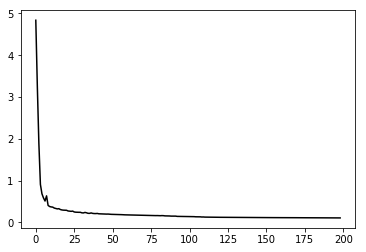

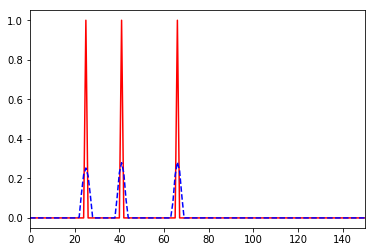

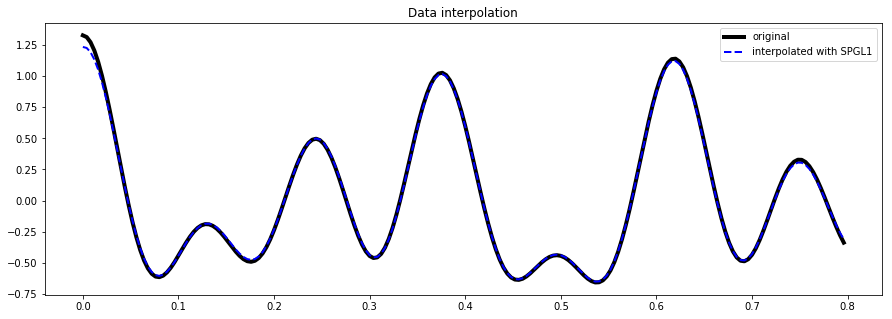

In [14]:
xspgl1, Xspgl1, info = SPGL1(Rop, y, FFTop, tau=3, iter_lim=200)

plt.figure()
plt.plot(info['rnorm2'], 'k')

plt.figure()
plt.plot(X,'r')
plt.plot(Xspgl1, '--b')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t, x,       'k'   , LineWidth=4,   label='original')
plt.plot(t, xspgl1,  '--b' , LineWidth=2,   label='interpolated with SPGL1')
plt.legend()
plt.title('Data interpolation');

## 2D Interpolation

The same optimization routines can be used to solve multi-dimensional problems. In this case we consider the problem of interpolating a 2d array (i.e., an image).

/Users/matteoravasi/anaconda/envs/pylops/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


cg reason for termination= 0
lsqr reason for termination= 7
lsqr number of iterations= 200
lsqr residual norm of iterations= 1712.9696538490355
lsqr regularized residual norm= 1712.9696538490355


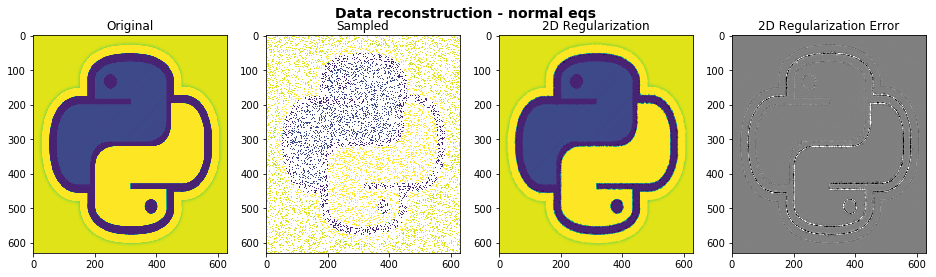

In [15]:
im = np.asarray(misc.imread('../../pylops/testdata/python.png'))[:,:,0]
Nz , Nx = im.shape

# Subsample signal
N=im.shape[0]*im.shape[1]
perc_subsampling=0.2
Nsub2d=int(np.round(N*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(N))[:Nsub2d])
        
# Create operators and data
Rop  = Restriction(N, iava, dtype='float64')
D2op = Laplacian([Nz,Nx], weights=[1,1], dtype='float64')

dottest(Rop,Nsub2d,N)

x  = im.flatten()
y  = Rop.matvec(x)
y1 = Rop.mask(x)

# Invert for interpolated signal, normal equations
xcg_reg_lop, istop = \
    NormalEquationsInversion(Rop, [D2op], y, epsRs=[np.sqrt(0.1)], returninfo=True,
                             **dict(maxiter=200))
print('cg reason for termination=', istop)

# Invert for interpolated signal, lsqrt
xlsqr_reg_lop, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y, epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=0, iter_lim=200 ,show=0))
print('lsqr reason for termination=', istop)
print('lsqr number of iterations=', itn)
print('lsqr residual norm of iterations=', r1norm)
print('lsqr regularized residual norm=', r2norm)

im_rec_lap_cg   = xcg_reg_lop.reshape((Nz,Nx))
im_rec_lap_lsqr = xlsqr_reg_lop.reshape((Nz,Nx))
im_sampled = y1.reshape((Nz,Nx))

# Visualize results
fig, axs = plt.subplots(1, 4, figsize=(16,4))
fig.suptitle('Data reconstruction - normal eqs',fontsize=14, fontweight='bold')
axs[0].imshow(im,cmap='viridis', vmin=0, vmax=250)
axs[0].axis('tight')
axs[0].set_title('Original')
axs[1].imshow(im_sampled, cmap='viridis', interpolation=None, vmin=0, vmax=250)
axs[1].axis('tight')
axs[1].set_title('Sampled')
axs[2].imshow(im_rec_lap_cg,cmap='viridis', vmin=0, vmax=250)
axs[2].axis('tight')
axs[2].set_title('2D Regularization')
axs[3].imshow(im - im_rec_lap_cg,cmap='gray', vmin=-80, vmax=80)
axs[3].axis('tight')
axs[3].set_title('2D Regularization Error');